# Homework 3 - Unsupervised Learning
## Name: Sondre Kongsgaard
## Collaboration group: Anders Vagle, Brage Saether, Morten Lie

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

N = 200 # Number of samples

def generate_gaussian_components(N):
    m_1 = [0, 0]
    C_1 = [[2, 0], [0, 1]]
    m_2 = [-2, 1]
    C_2 = [[9.0/8, 7.0/8], [7.0/8, 9.0/8]]
    m_3 = [3, 2]
    C_3 = [[2, 1], [1, 2]]
    
    pi_1 = 1.0/2
    pi_2 = 1.0/6
    
    x = np.zeros((N, 2))
    z = np.zeros((N, 3)) # One-hot encoding
    for i in range(0, N):
        a = random.uniform(0, 1)
        if (a < pi_1):
            x[i, :] = np.random.multivariate_normal(m_1, C_1, 1)
            z[i][0] = 1
        elif (a < pi_1 + pi_2):
            x[i, :] = np.random.multivariate_normal(m_2, C_2, 1)
            z[i][1] = 1
        else:
            x[i, :] = np.random.multivariate_normal(m_3, C_3, 1)
            z[i][2] = 1
    return x, z

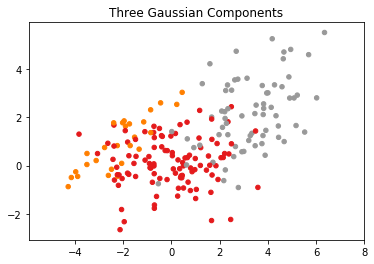

In [2]:
# Three Gaussian components, N samples
x, z = generate_gaussian_components(N)
plt.scatter(x[:, 0], x[:, 1], c=np.where(z)[1], s=20, cmap='Set1')
plt.axis('equal')
plt.title("Three Gaussian Components")
plt.show()

# 1) Implementation of K-means algorithm

In [3]:
def k_means(N, K, C, x):
    C_new = np.zeros((N, 1))
    m = np.zeros((K, 2))
    while True:
        # Assignment step
        for i in range(N):
            min_distance = math.inf
            for j in range(1, K + 1):
                distance = np.linalg.norm(x[i] - m[j-1])
                if distance < min_distance:
                    C_new[i] = j
                    min_distance = distance
        
        # Update step
        for j in range(1, K + 1):
            C_abs = 0
            for i in range(N):
                if C[i] == j:
                    C_abs += 1
                    m[j-1][:] += x[i][:]
            if C_abs == 0:
                C_abs = 1
            m[j-1, :] /= C_abs
        
        # Check for convergence
        if np.all(C_new == C):
            return C_new, m
        
        C = C_new
        
def mean_squared_error(x,C,m):
    N = len(x)
    K = len(m)
    smse = np.zeros((K,1))
    for i in range(N):
        j = int(C[i])
        smse[j-1] += np.linalg.norm(x[i] - m[j-1])
    mse = np.sum(smse) / N
    return mse

In [4]:
n_random_initializations = 5
K_max = 5

C_optimal = np.zeros((N, K_max))
m_optimal = np.zeros((K_max, 2, K_max))

for K in range(2, K_max+1):
    min_mse = math.inf
    for i in range(n_random_initializations):
        C = np.random.randint(1, high=K+1, size=(N, 1)) # Exclusive high
        C, m = k_means(N,K,C,x)
        mse = mean_squared_error(x,C,m)
        if mse < min_mse:
            C_optimal[:, K-1] = C.T
            m_optimal[0:K, :, K-1] = m
            min_mse = mse
print("K-means complete")

K-means complete


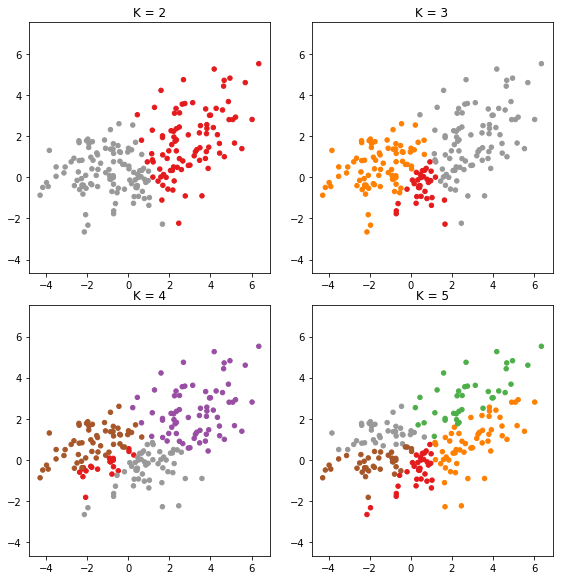

In [5]:
# Compute one-hot encoding 
a = np.zeros((N, K_max, K_max))
for K in range(2, K_max + 1):
    for i in range(N):
        a[i][int(C_optimal[i][K-1])-1][K-1] = 1

fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.tight_layout()
for K in range(2, K_max+1):
    row = int(K/2) - 1
    col = (K - 2) % 2
    axes[row, col].scatter(x[:, 0], x[:, 1], c=np.where(a[:,:,K-1])[1], s=20, cmap='Set1')
    axes[row, col].set_title("K = %s"%K)
    axes[row, col].axis('equal')
plt.show()

In [6]:
# Plot empirical probabilities
# TODO: def plot_empirical_probabilities:
empirical_probabilities = np.zeros((3, K_max, K_max))
for K in range(2, K_max+1):
    for li in range(3):
        for j in range(K):
            num_a = 0
            num_z = 0
            for i in range(N):
                if z[i, li] == 1:
                    num_z += 1
                    if a[i, j, K-1] == 1:
                        num_a += 1
            empirical_probabilities[li, j, K-1] = num_a / num_z

print(empirical_probabilities)

[[[0.         0.24038462 0.29807692 0.18269231 0.28846154]
  [0.         0.75961538 0.49038462 0.09615385 0.06730769]
  [0.         0.         0.21153846 0.28846154 0.19230769]
  [0.         0.         0.         0.43269231 0.26923077]
  [0.         0.         0.         0.         0.18269231]]

 [[0.         0.03703704 0.         0.03703704 0.        ]
  [0.         0.96296296 0.96296296 0.07407407 0.07407407]
  [0.         0.         0.03703704 0.88888889 0.        ]
  [0.         0.         0.         0.         0.37037037]
  [0.         0.         0.         0.         0.55555556]]

 [[0.         0.94202899 0.02898551 0.         0.04347826]
  [0.         0.05797101 0.04347826 0.84057971 0.4057971 ]
  [0.         0.         0.92753623 0.02898551 0.52173913]
  [0.         0.         0.         0.13043478 0.        ]
  [0.         0.         0.         0.         0.02898551]]]


# 2) Implementation of EM algorithm

In [7]:
from scipy.stats import multivariate_normal

def EM(m, C, pi, N, K, x, max_iter=10):
    for iter in range(max_iter):
        # Assignment step (E step)
        p_k = np.zeros((N, K))
        for i in range(N):
            pi_norm_distribution = np.zeros((K,1))
            for j in range(K):
                mvn = multivariate_normal(m[j], C[j])
                pi_norm_distribution[j] = pi[j] * mvn.pdf(x[i, :])
            for j in range(K):
                p_k[i, j] = pi_norm_distribution[j] / np.sum(pi_norm_distribution)
            
        # Update step (M step)
        for j in range(K):
            num = 0
            for i in range(N):
                num += p_k[i, j] * x[i, :]
            m[j] = num / np.sum(p_k[:, j])
            
            num = 0
            for i in range(N):
                num += p_k[i, j] * np.outer(x[i, :] - m[j], x[i, :] - m[j])
            C[j] = num / np.sum(p_k[:, j])
            
            pi[j] = np.sum(p_k[:, j]) / N

    return m, C, pi
        
m_EM = np.zeros((K_max, 2, K_max))
C_EM = np.zeros((K_max, K_max, 2, 2))
for K in range(2, K_max+1):
    C_EM_initial = np.repeat(np.eye(2)[np.newaxis, :, :], K, axis=0)
    m_EM_initial = m_optimal[0:K, :, K-1]
    pi_EM_initial = 1/K * np.ones((K,1))

    m_EM[0:K, :, K-1], C_EM[K-1, 0:K], pi_EM = EM(m_EM_initial, C_EM_initial, pi_EM_initial, N, K, x)

print("EM complete")

EM complete


# 3) Geometrically find visualization of means and covariances as a contour plot

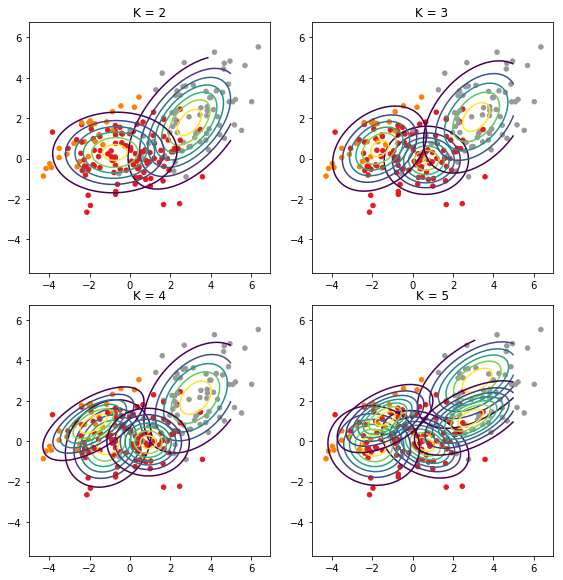

In [8]:
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.
    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

X = np.linspace(-5, 5, N)
Y = np.linspace(-5, 5, N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.tight_layout()
for K in range(2, K_max+1):
    row = int(K/2) - 1
    col = (K - 2) % 2
    axes[row, col].scatter(x[:, 0], x[:, 1], c=np.where(z)[1], s=20, cmap='Set1')
    for j in range(K):
        Z = multivariate_gaussian(pos, m_EM[j,:,K-1], C_EM[K-1, j])
        axes[row, col].contour(X, Y, Z)
    axes[row, col].set_title("K = %s"%K)
    axes[row, col].axis('equal')
plt.show()

Further experiments will be done with higher dimensional data
# 4) Generate a random vector $\mathbf{u}$ in $d$ dimensions

In [9]:
d = 30

def generate_random_vector(d):
    u = np.zeros((d, 1)) 
    P_1 = 2.0/3
    P_2 = 1.0/6
    for i in range(d):
        a = random.uniform(0, 1)
        if (a < P_1):
            u[i] = 0
        elif (a < P_1 + P_2):
            u[i] = 1
        else:
            u[i] = -1
    return u

u = np.zeros((d, 7))
for j in range(7):
    u[:,j] = generate_random_vector(d).T
print(u) # Manually inspect that the vectors u_j, j=1,...,7 are quasi-orthogonal

[[ 0.  0.  0.  0. -1. -1.  0.]
 [ 0.  0.  0. -1. -1.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0. -1.]
 [ 0.  1.  0.  1. -1. -1.  0.]
 [ 0. -1.  0.  0. -1.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  1.  0. -1. -1. -1.  0.]
 [ 0.  0.  0. -1. -1.  0. -1.]
 [-1. -1.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  1. -1.  0.]
 [ 0.  1.  0.  0. -1. -1.  0.]
 [ 0.  0.  0. -1.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  1.]
 [ 0.  1.  0.  1.  0.  0.  1.]
 [ 0. -1.  1. -1. -1. -1.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  1.  0.  1.  0.  0.]
 [ 0.  1. -1.  0. -1.  0.  1.]
 [ 0.  0.  0.  1.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  1.  0.  0. -1.  0.]
 [ 1.  0.  0.  0.  0. -1.  1.]
 [ 1.  0.  1.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0. -1.  1.]
 [ 1.  0. -1.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]


# 5) Generate $d$-dimensional  data samples for a Gaussian mixture distribution with 3 equiprobable components

In [10]:
def generate_d_dimensional_gaussian_components(N, d, u):

    pi_1 = 1.0 / 3
    pi_2 = 1.0 / 3

    sigma_squared = 0.01

    x = np.zeros((N, d))
    z = np.zeros((N, 3)) # One-hot encoding
    for i in range(N):
        Z_1 = np.random.normal(0, 1, 1)
        Z_2 = np.random.normal(0, 1, 1)
        noise = np.random.multivariate_normal(np.zeros(d), sigma_squared*np.eye(d), 1)

        a = random.uniform(0, 1)
        if (a < pi_1):
            x[i, :] = u[:, 0] + Z_1*u[:, 1] + Z_2*u[:, 2] + noise
            z[i][0] = 1
        elif (a < pi_1 + pi_2):
            x[i, :] = 2*u[:, 3] + math.sqrt(2)*Z_1*u[:, 4] + Z_2*u[:, 5] + noise
            z[i][1] = 1
        else:
            x[i, :] = math.sqrt(2)*u[:, 5] + Z_1*(u[:, 0] + u[:, 1]) + 1.0/math.sqrt(2)*Z_2*u[:,4] + noise
            z[i][2] = 1
    return x, z

# 6) Generate N data samples from the preceding model

In [11]:
N = 10 # TODO: To be determined
x, z = generate_d_dimensional_gaussian_components(N, d, u)